# Setup and loading ViT-B_32

In [1]:
! pip install -qq -U tensorflow-addons
! pip install vit-keras

     |████████████████████████████████| 1.1 MB 16.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=0edce907edc4dfd59a51be41b331c62b32ea4d54d948ad1f77a246976b5b1829
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators


In [2]:
from vit_keras import vit, utils
from vit_keras import visualize


In [3]:
# saving cells may be omitted
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!git clone https://gitlab.com/juan.ardiles/Cifar10/

Cloning into 'Cifar10'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 69 (delta 15), reused 0 (delta 0), pack-reused 18
Unpacking objects: 100% (69/69), done.
Checking out files: 100% (23/23), done.


In [4]:
## Hyperparameters

BATCH_SIZE = 16
IMAGE_SIZE = 32

# OPTIMIZER
learning_rate = 1e-4

# TRAINING
EPOCHS = 3
DISTILL_EPOCHS = 20


In [5]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 10)

353253686/353253686 [==============================] - 99s 0us/step


/usr/local/lib/python3.8/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 1, 1
  warnings.warn(


In [6]:
vit_model.summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 embedding (Conv2D)          (None, 1, 1, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 1, 768)            0         
                                                                 
 class_token (ClassToken)    (None, 2, 768)            768       
                                                                 
 Transformer/posembed_input   (None, 2, 768)           1536      
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 2, 768),         7087872   
 (TransformerBlock)           (None, 12, None, None))      

# Preparing the data

In [7]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L


In [8]:
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)



170498071/170498071 [==============================] - 13s 0us/step


In [9]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

# Cifar10 Fine Tuning

In [10]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(NUM_CLASSES)
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87418368  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)         

In [11]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

history = model.fit(x_train,
          y_train,
          epochs=EPOCHS*4,
          batch_size=BATCH_SIZE,
          callbacks=callbacks,
          validation_data=(x_test, y_test))


Epoch 1/12
3125/3125 [==============================] - ETA: 0s - loss: 1.7060 - accuracy: 0.4179
Epoch 1: val_accuracy improved from -inf to 0.58930, saving model to ./model.hdf5
3125/3125 [==============================] - 286s 83ms/step - loss: 1.7060 - accuracy: 0.4179 - val_loss: 1.2334 - val_accuracy: 0.5893 - lr: 1.0000e-04
Epoch 2/12
3125/3125 [==============================] - ETA: 0s - loss: 1.2054 - accuracy: 0.6065
Epoch 2: val_accuracy improved from 0.58930 to 0.59700, saving model to ./model.hdf5
3125/3125 [==============================] - 261s 84ms/step - loss: 1.2054 - accuracy: 0.6065 - val_loss: 1.2075 - val_accuracy: 0.5970 - lr: 1.0000e-04
Epoch 3/12
3125/3125 [==============================] - ETA: 0s - loss: 1.0549 - accuracy: 0.6553
Epoch 3: val_accuracy improved from 0.59700 to 0.65430, saving model to ./model.hdf5
3125/3125 [==============================] - 260s 83ms/step - loss: 1.0549 - accuracy: 0.6553 - val_loss: 1.0209 - val_accuracy: 0.6543 - lr: 1.0000

In [12]:
model.save_weights('model.h5')
np.save('vit_history.npy',history.history)

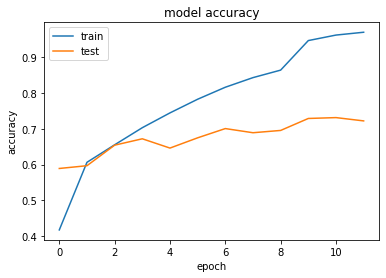

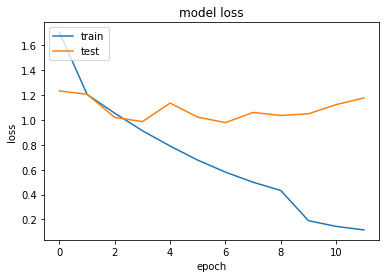

In [14]:
# summarize history for accuracy


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/model_tuned.h5')
np.save('/content/drive/MyDrive/Colab Notebooks/vit_tuned_history.npy',history.history)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/model_tuned.h5')

# ViT distilling into a CNN

In [16]:
def nn_callbacks():
    es = keras.callbacks.EarlyStopping(
        patience=5, verbose=1, restore_best_weights=True, min_delta=1e-4
    )
    rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
    return [es, rlp]

In [17]:
class Distiller(keras.Model):
    def __init__(self, student, teacher, activation):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.activation = activation

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=student_loss_fn)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                self.activation(teacher_predictions / self.temperature, axis=1),
                self.activation(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
        student_predictions = self.student(x, training=False)
        
        student_loss = self.student_loss_fn(y, student_predictions)
        distillation_loss = self.distillation_loss_fn(
            self.activation(teacher_predictions / self.temperature, axis=1),
            self.activation(student_predictions / self.temperature, axis=1),
        )
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results
    
    def call(self, x):
        return self.student(x)

In [18]:
N_CLASSES = y_train.shape[-1]
INPUT_SHAPE = x_train.shape[1:]

def build_student_model(name='student'):
    return keras.models.Sequential([
        L.Conv2D(64, 3, input_shape=INPUT_SHAPE, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.Conv2D(64, 3, padding='same', activation='relu'),
        L.MaxPool2D(pool_size=2),
        L.GlobalAvgPool2D(),
        L.Dense(N_CLASSES),
    ],name=name) 

student_model = build_student_model()
student_model.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        36928     
                                                           

In [19]:
d_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
d_valid = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [20]:
BATCH = 512

distiller = Distiller(student_model, model, tf.nn.softmax)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=20,
)
history2 = distiller.fit(
    d_train.shuffle(1024, 19).batch(BATCH), 
    validation_data=d_valid.shuffle(1024, 19).batch(BATCH),
    epochs=DISTILL_EPOCHS, callbacks=nn_callbacks(), batch_size=BATCH
)
np.save('history2.npy',history2.history)

Epoch 1/20
98/98 [==============================] - 34s 257ms/step - accuracy: 0.1417 - student_loss: 2.2341 - distillation_loss: 0.0073 - loss: 1.5661 - val_accuracy: 0.2046 - val_student_loss: 2.0560 - val_distillation_loss: 0.0063 - val_loss: 1.4411 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 21s 211ms/step - accuracy: 0.3071 - student_loss: 1.8091 - distillation_loss: 0.0063 - loss: 1.2683 - val_accuracy: 0.3583 - val_student_loss: 1.6532 - val_distillation_loss: 0.0056 - val_loss: 1.1589 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 21s 212ms/step - accuracy: 0.4062 - student_loss: 1.5695 - distillation_loss: 0.0058 - loss: 1.1004 - val_accuracy: 0.4317 - val_student_loss: 1.5100 - val_distillation_loss: 0.0048 - val_loss: 1.0584 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 21s 213ms/step - accuracy: 0.4821 - student_loss: 1.3924 - distillation_loss: 0.0056 - loss: 0.9763 - val_accuracy: 0.4899 - val_student_loss: 1.3542 

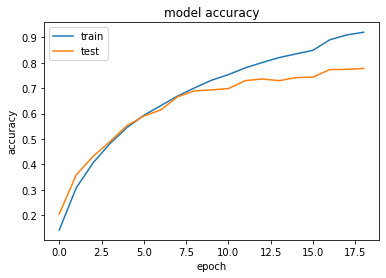

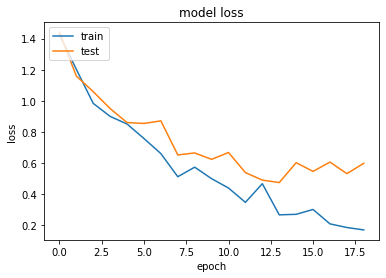

In [21]:
# summarize history for accuracy


plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Multiteacher distillation with CNN assist

In [22]:
teacher1 = tf.keras.models.load_model('Cifar10/teacher1.h5')

In [23]:
class Distiller2(keras.Model):
    def __init__(self, student, teacher1, teacher2,activation):
        super().__init__()
        self.teacher1 = teacher1
        self.teacher2 = teacher2
        self.student = student
        self.activation = activation

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=10,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=student_loss_fn)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher1(x, training=False)
        teacher2_predictions = self.teacher2(x, training=False)


        teacher_promedio = teacher_predictions*0.5 + teacher2_predictions*0.5

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                self.activation(teacher_promedio / self.temperature, axis=1),
                self.activation(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results

    def test_step(self, data):
        x, y = data
        teacher_predictions = self.teacher1(x, training=False)
        teacher2_predictions = self.teacher2(x, training=False)

        student_predictions = self.student(x, training=False)
        
        teacher_promedio = teacher_predictions*0.5 + teacher2_predictions*0.5
        student_loss = self.student_loss_fn(y, student_predictions)
        distillation_loss = self.distillation_loss_fn(
            self.activation(teacher_promedio / self.temperature, axis=1),
            self.activation(student_predictions / self.temperature, axis=1),
        )
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, "loss": loss}
        )
        return results
    
    def call(self, x):
        return self.student(x)

In [24]:
student2_model = build_student_model()
distiller2 = Distiller2(student2_model, teacher1, model, tf.nn.softmax)
distiller2.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=100,
)
history2 = distiller2.fit(
    d_train.shuffle(1024, 19).batch(BATCH), 
    validation_data=d_valid.shuffle(1024, 19).batch(BATCH),
    epochs=DISTILL_EPOCHS, callbacks=nn_callbacks(), batch_size=BATCH
)
np.save('history2.npy',history2.history)

Epoch 1/20
98/98 [==============================] - 44s 364ms/step - accuracy: 0.1852 - student_loss: 2.1391 - distillation_loss: 5.3019e-04 - loss: 1.4976 - val_accuracy: 0.2499 - val_student_loss: 1.9668 - val_distillation_loss: 4.7253e-04 - val_loss: 1.3769 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 29s 298ms/step - accuracy: 0.3267 - student_loss: 1.7857 - distillation_loss: 3.9541e-04 - loss: 1.2501 - val_accuracy: 0.3693 - val_student_loss: 1.7285 - val_distillation_loss: 3.3512e-04 - val_loss: 1.2101 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 29s 300ms/step - accuracy: 0.4104 - student_loss: 1.5685 - distillation_loss: 3.2683e-04 - loss: 1.0981 - val_accuracy: 0.4623 - val_student_loss: 1.4403 - val_distillation_loss: 2.9045e-04 - val_loss: 1.0083 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 29s 301ms/step - accuracy: 0.4916 - student_loss: 1.3637 - distillation_loss: 2.7398e-04 - loss: 0.9547 - val_accuracy: 0.4965

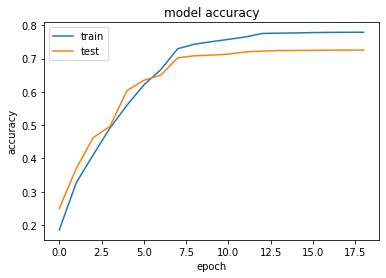

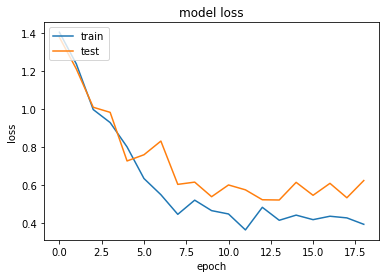

In [25]:
# summarize history for accuracy


plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
student_model.save_weights('/content/drive/MyDrive/Colab Notebooks/student_only_vit.h5')
student2_model.save_weights('/content/drive/MyDrive/Colab Notebooks/student_vit_and_cnn.h5')